In [1]:
# This script is used to analyse the ramp PETCO2 data and TCD data and plot TCD MCA mean velocity as a function of ETCO2

In [2]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import fft, ifft
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
sys.path.append('..')
import ramp_cvr_functions as cvr_func
import copy
import csv


# Set TCD calibration factor (determined from DWL Dopler BoxX manual) and cut-off threshold (erroneous TCD values are set to NaN if below threshold)
QL_scale_max = 202 # QL scale maximum in cm/s
## DELETE TCD_calibration_factor = QL_scale_max*2/2.5 # **OLD** TCD calibration factor in cm/s/V
TCD_calibration_factor = 202.07 # TCD calibration factor in cm/s/V
print('TCD calibration factor (cm/s/V):', TCD_calibration_factor)
TCD_threshold = 0.07*TCD_calibration_factor # TCD threshold in cm/s
print('TCD threshold (cm/s):', TCD_threshold)
O2_height = -20 # O2 valley 'height' for peak detection in %


save_fig = False

TCD calibration factor (cm/s/V): 202.07
TCD threshold (cm/s): 14.144900000000002


In [3]:
local = '/Users/ghayes/Desktop/ramp_protocol/data/TCD/'
outdir = '/Users/ghayes/Desktop/ramp_protocol/data/TCD/tcd_proc/'
man_shift=0
peak_dif_thresh = 0.4 #% difference between PETCO2 peaks

# ### RAMP WITH NEW NEW MASK ###
# filename = 'sub-026_ses-01_dat-20240523_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# man_shift=500
# peak_dif_thresh = 0.9
# P_oxford = 1011.1 # hPa aka mbar (Oxford)

# filename = 'sub-027_ses-01_dat-20240523_task-ramp_pwl_incomplete.txt'
# O2prominence = 1.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 1.1
# man_shift=-2300
# P_oxford = 1011.1 # hPa aka mbar (Oxford)

# ------------
# #SUB-021, MR-003
# filename = 'sub-021/ses-01/sub-021_ses-01_dat-20240423_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# man_shift=-3000
# peak_dif_thresh = 0.9
# P_oxford = 1019.1 # hPa aka mbar (Oxford)

# #SUB-022, MR-004
# filename = 'sub-022/ses-01/sub-022_ses-01_dat-20240423_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1019.1 # hPa aka mbar (Oxford)

# #SUB-023, MR-005
# filename = 'sub-023/ses-01/sub-023_ses-01_dat-20240430_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1007.1 # hPa aka mbar (Oxford)

# #SUB-025, MR-006
# filename = 'sub-025/ses-01/sub-025_ses-01_dat-20240509_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1022.6 # hPa aka mbar (Oxford)

# #SUB-024, MR-007
# filename = 'sub-024/ses-01/sub-024_ses-01_dat-20240508_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1024.2 # hPa aka mbar (Oxford)

# #SUB-026, MR-008
# filename = 'sub-026/ses-01/sub-026_ses-01_dat-20240523_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1011.1 # hPa aka mbar (Oxford)

# #SUB-029, MR-009
# filename = 'sub-029/ses-01/sub-029_ses-01_dat-20240611_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1015.7 # hPa aka mbar (Oxford)

# #SUB-035, MR-010
# filename = 'sub-035/ses-01/sub-035_ses-01_dat-20240724_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1017 # hPa aka mbar (Oxford)

# # SUB-032, MR-011
# filename = 'sub-032/ses-01/sub-032_ses-01_dat-20240719_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1013.4 # hPa aka mbar (Oxford)

# #SUB-031, MR-012
# filename = 'sub-031/ses-01/sub-031_ses-01_dat-20240715_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 2
# peak_dif_thresh = 0.9
# P_oxford = 1005.4 # hPa aka mbar (Oxford)

# #SUB-044, MR-013
# filename = 'sub-044/ses-01/sub-044_ses-01_dat-20240812_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1005.3 # hPa aka mbar (Oxford)

# #SUB-045, MR-014
# filename = 'sub-045/ses-01/sub-045_ses-01_dat-20240815_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1010.5 # hPa aka mbar (Oxford)

# #SUB-039, MR-015
# filename = 'sub-039/ses-01/sub-039_ses-01_dat-20240726_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1009 # hPa aka mbar (Oxford)

# #SUB-036, MR-016
# filename = 'sub-036/ses-01/sub-036_ses-01_dat-20240725_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1007.7 # hPa aka mbar (Oxford)

# #SUB-042, MR-017
# filename = 'sub-042/ses-01/sub-042_ses-01_dat-20240807_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1009.3 # hPa aka mbar (Oxford)

# #SUB-037, MR-019
# filename = 'sub-037/ses-01/sub-037_ses-01_dat-20240726_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1009 # hPa aka mbar (Oxford)

# #SUB-046, MR-020
# filename = 'sub-046/ses-01/sub-046_ses-01_dat-20240822_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1002.3 # hPa aka mbar (Oxford)

#SUB-009, MR-021
filename = 'sub-009/ses-02/sub-009_ses-02_dat-20240830_task-ramp_pwl.txt'
O2prominence = 0.5
comment_start = 0
comment_end = 1
peak_dif_thresh = 0.9
P_oxford = 1020 # hPa aka mbar (Oxford)

# #SUB-050, MR-022
# filename = 'sub-050/ses-01/sub-050_ses-01_dat-20240903_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1010.9 # hPa aka mbar (Oxford)

# #SUB-047, MR-023
# filename = 'sub-047/ses-01/sub-047_ses-01_dat-20240823_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1004.2 # hPa aka mbar (Oxford)

# #SUB-048, MR-024
# filename = 'sub-048/ses-01/sub-048_ses-01_dat-20240823_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1004.2 # hPa aka mbar (Oxford)

# #SUB-38, MR-026
# filename = 'sub-038/ses-01/sub-038_ses-01_dat-20240726_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1009 # hPa aka mbar (Oxford)

# #SUB-41, MR-027
# filename = 'sub-041/ses-01/sub-041_ses-01_dat-20240805_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.9
# P_oxford = 1009.8 # hPa aka mbar (Oxford)

# #SUB-051, MR-028
# filename = 'sub-051/ses-01/sub-051_ses-01_dat-20241025_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.4
# P_oxford = 1013 # hPa aka mbar (Oxford)

# #SUB-052, MR-029
# filename = 'sub-052/ses-01/sub-052_ses-01_dat-20241105_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 1
# peak_dif_thresh = 0.6
# P_oxford = 1023 # hPa aka mbar (Oxford)


In [4]:
P_conversion_perc2mmHg = P_oxford*(0.75006157584566)/100 # conversion factor from % gas concentration to mmHg
filepath = local + filename
print(filepath)

/Users/ghayes/Desktop/ramp_protocol/data/TCD/sub-009/ses-02/sub-009_ses-02_dat-20240830_task-ramp_pwl.txt


In [5]:
# Read text file into pandas DataFrame
cols = pd.read_csv(filepath, sep='\t', nrows=5, header=(4)).columns
# Delete the first column
cols = cols.drop(cols[0])
cols = cols.insert(0, 'Time')
# Add a column to the DataFrame
cols = cols.insert(5, 'Comments')
# Read the file into a DataFrame
df_raw = pd.read_csv(filepath, sep='\t',skiprows=(0,1,2,3,4,5,6),header=None, names=cols) 
 
# List the rows with comments
rows_comments=df_raw[df_raw['Comments'].notnull()]
print('--- COMMENTS ---')
print(rows_comments)

--- COMMENTS ---
            Time  Channel 1 -CO2  Channel 2 - O2  Channel 3 - TCD  \
45059    225.300        4.952188        16.61563         0.248594   
204718  1023.595        4.965625        15.65938         0.217969   

        Channel 4 - Pulse   Comments  
45059           -0.059562  #* start   
204718          -0.227563   #* stop   


In [6]:
# Print the index of comment_start
print('--- COMMENT START ---')
print('Index of comment_start:', rows_comments.index[comment_start])

# Print the index of comment_end
print('--- COMMENT END ---')
print('Index of comment_end:', rows_comments.index[comment_end])

--- COMMENT START ---
Index of comment_start: 45059
--- COMMENT END ---
Index of comment_end: 204718


In [7]:
# Get indices of comments that include the word 'remove'
remove_indices = rows_comments[rows_comments['Comments'].str.contains('remove')].index.tolist()

print('--- REMOVE INDICES ---')
print(remove_indices)

--- REMOVE INDICES ---
[]


In [8]:
# Filenaming conventions for saving files and figures
# get the original file name and remove the extension
filename_split = filename.split('.')
# remove the first element if it is 'new'
if filename_split[0] == 'new':
    filename_split = filename_split[1:]
# if there are / in the filename, split by / and take the last element
filename_split = filename_split[0].split('/')
filename_split = filename_split[-1]
# get sub and ses number
sub_ses = filename_split.split('_')

# remove the first element if it is 'new'
if sub_ses[0] == 'new':
    sub_ses = sub_ses[1:]

sub = sub_ses[0]
ses = sub_ses[1]

# get the date
date = filename_split.split('-')
date = date[3]
# get the task
task = filename_split.split('_')
task = task[3]

print('--- FILENAMES ---')
print('Subject:', sub)
print('Session:', ses)
print('Date:', date)
print('Task:', task)

sub_outdir = outdir + sub + '/' + ses + '/' 
print('sub_outdir:', sub_outdir)
# make a directory for the processed data if it doesn't already exist
if not os.path.exists(sub_outdir):
    os.makedirs(sub_outdir)

--- FILENAMES ---
Subject: sub-009
Session: ses-02
Date: 20240830_task
Task: task-ramp
sub_outdir: /Users/ghayes/Desktop/ramp_protocol/data/TCD/tcd_proc/sub-009/ses-02/


In [9]:
# # MANUALLY REMOVE SECTIONS 
# # insert comment for remove_start and remove_stop
# remove_start_manual_1 = 173000
# remove_stop_manual_1 = 190000

# # add comments to remove indices list
# remove_indices.append(remove_start_manual_1)
# remove_indices.append(remove_stop_manual_1)
# # re-order list (accending order)
# remove_indices.sort()

# print('--- REMOVE INDICES ---')
# print(remove_indices)


In [10]:
df_all = cvr_func.get_data_between_comments(df_raw, comment1_index=comment_start, comment2_index=comment_end, crop_start=1, crop_end=1)
print('--- DATAFRAME INFO ---')
# Print the firt element of time
print('Start of data window:', df_all.iloc[0][0], 's')
# Print the last element of time
print('End of data window:', df_all.iloc[-1][0], 's')
print('Length of data window:', float(df_all.iloc[-1][0]) - float(df_all.iloc[0][0]), 's')

--- DATAFRAME INFO ---
Start of data window: 226.3 s
End of data window: 1022.59 s
Length of data window: 796.29 s


/Users/ghayes/Documents/GitHub/End-Tidal-Extraction/ramp-protocol/mri-edition/../ramp_cvr_functions.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rate = 1/(float(dataframe.iloc[2][0]) - float(dataframe.iloc[1][0]))
/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_5648/333714664.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Start of data window:', df_all.iloc[0][0], 's')
/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_5648/333714664.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [11]:
# REMOVE DATA THAT HAS BEEN FLAGGED FOR REMOVAL
# get the index of the start of df_all
df_all_start_index = df_all.index[0]
diff = 0


if len(remove_indices) > 0:
     print('--- REMOVING DATA ---')
     print('Number of data windows to remove:', int(len(remove_indices)/2))
     max_final_ind = int(len(remove_indices)/2)
     print('max_final_ind:',max_final_ind)
     for i in range(0,max_final_ind):
         i = i*2
         print('index:',i)
         df_start_length = len(df_all)

         df_all = cvr_func.remove_data_between_comments(df_all, remove_indices[i]-df_all_start_index-diff, remove_indices[i+1]-df_all_start_index-diff)
         
         df_new_length = len(df_all)
         diff = df_start_length - df_new_length

In [12]:
### SEPERATE DATA ###

#get raw CO2 and O2 data
CO2 = pd.to_numeric(df_all.iloc[:,1], errors='coerce')
O2 = pd.to_numeric(df_all.iloc[:,2], errors='coerce')
#get raw TCD data
TCD = pd.to_numeric(df_all.iloc[:,3], errors='coerce')*TCD_calibration_factor
#get raw PPG data
PPG = pd.to_numeric(df_all.iloc[:,4], errors='coerce')

print(CO2)

45259     5.386875
45260     5.389375
45261     5.391875
45262     5.394375
45263     5.396875
            ...   
204513    0.254062
204514    0.263750
204515    0.274375
204516    0.285313
204517    0.296875
Name: Channel 1 -CO2, Length: 159259, dtype: float64


In [13]:
sample_rate = 1/(float(df_all.iloc[2][0]) - float(df_all.iloc[1][0]))

# #### SHIFT CO2 AND O2 DATA RELATIVEL TO THE TCD DATA ####
# gas_shift_time = 0.01 # seconds

# # Shift CO2 and O2 data to account for 2 second delay in nasal cannula to gas analyser measurement (note 200 Hz sampling rate)
# print ('--- SHIFTING CO2 AND O2 DATA ---')
# sample_rate = 1/(float(df_all.iloc[2][0]) - float(df_all.iloc[1][0]))
# gas_shift = int(gas_shift_time*sample_rate)
# print('gas_shift:',gas_shift, 'indices')

# CO2 = CO2.shift(periods=gas_shift, fill_value=np.nan)
# O2 = O2.shift(periods=gas_shift, fill_value=np.nan)


/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_5648/2311148443.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rate = 1/(float(df_all.iloc[2][0]) - float(df_all.iloc[1][0]))


In [14]:
#plt.plot(TCD)
#plt.plot(CO2)
#plt.plot(C)

In [15]:
#### MASK CO2 DATA #### 

# Remove CO2 values above 100% CO2 (stopping and starting of the DAQ can cause erroneous values which are very large, this removes them)
CO2 = CO2.mask(CO2 > 100)
# calculate the index of the CO2 values above 100cm/s
CO2_above_100 = CO2[CO2 > 100]
# remove this index from the O2 and TCD data as well
O2 = O2.drop(CO2_above_100.index)
TCD = TCD.drop(CO2_above_100.index)
PPG = PPG.drop(CO2_above_100.index)

## Remove CO2 values below 2.5%
#CO2 = CO2.mask(CO2 < 2.9)

# print CO2 values
print('--- CO2 VALUES ---')
print(CO2)
# print the number of NaN values in the data
print('Number of NaN values in CO2:', CO2.isnull().sum())

--- CO2 VALUES ---
45259     5.386875
45260     5.389375
45261     5.391875
45262     5.394375
45263     5.396875
            ...   
204513    0.254062
204514    0.263750
204515    0.274375
204516    0.285313
204517    0.296875
Name: Channel 1 -CO2, Length: 159259, dtype: float64
Number of NaN values in CO2: 0


<Axes: xlabel='Time (ms)', ylabel='PPG (V)'>

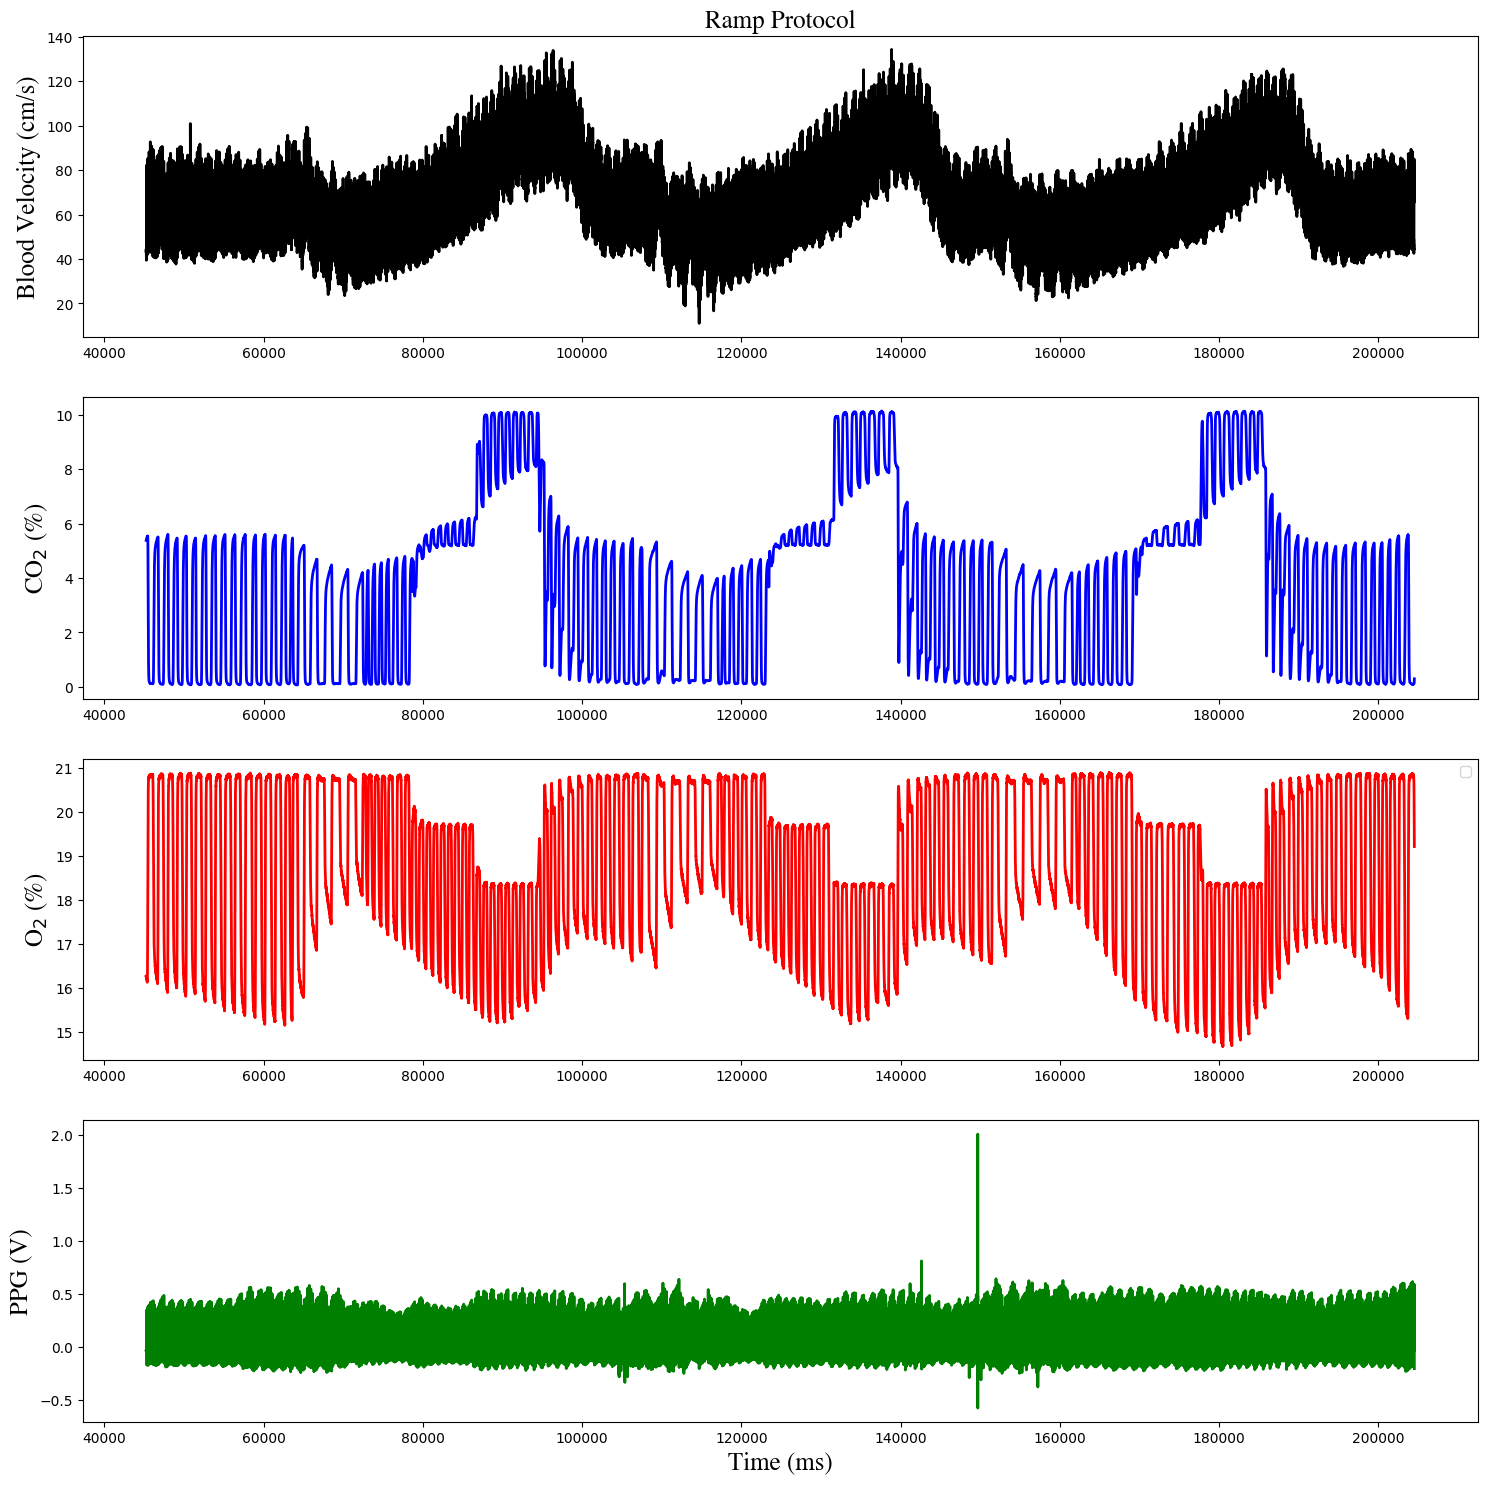

In [16]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp Protocol", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD.plot(c="black", lw=2)

#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (%)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)

#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2)
ax3.legend('')

#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="green", lw=2)

# #remove the x-axis ticks and numbers
# ax1.set_xticklabels([])
# ax2.set_xticklabels([])
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])


In [17]:
# Define search window as 0.5 seconds longer than the average breathing rate
br_avg, _, _, _ = cvr_func.get_average_breathing_rate(O2, sample_rate)
print('Average breathing rate:', 1/br_avg, 'seconds per breath')
# Define search window as 60% of the average breathing rate
search_window = (1/br_avg)*0.3
print('Sample rate:', sample_rate, 'Hz')
print('Search window:', search_window, 'seconds')

Average breathing rate: 5.728741007189034 seconds per breath
Sample rate: 200.0000000001819 Hz
Search window: 1.71862230215671 seconds


In [18]:
#### END TIDAL CO2 PEAKS FROM O2 VALLEYS ####

# Get the O2 end tidal val
TCD_th = copy.deepcopy(TCD)
#TCD_th[TCD_th < TCD_threshold] = np.nan

# print the starting index of the O2 data
print('--- O2 INDEX ---')
print(O2.index[0])
print(O2)

O2valleys_inds, O2valleys_vals, O2valleys_df = cvr_func.get_endtidal_valleys(np.array(O2), O2.index[0], search_window=search_window, sample_rate=200, height=O2_height, prominence=O2prominence)

# Define the end tidal CO2 peaks as the CO2 peaks that occur at each of the O2 valley points
CO2peaks_inds = O2valleys_inds
CO2peaks_vals = CO2[CO2peaks_inds]
# Make a dataframe of the CO2 peaks
CO2peaks_df = pd.DataFrame(CO2peaks_vals, index=CO2peaks_inds)
CO2peaks_df.columns = ['CO2']

--- O2 INDEX ---
45259
45259     16.26875
45260     16.26250
45261     16.25937
45262     16.26250
45263     16.25625
            ...   
204513    19.37188
204514    19.33438
204515    19.30000
204516    19.26250
204517    19.22187
Name: Channel 2 - O2, Length: 159259, dtype: float64


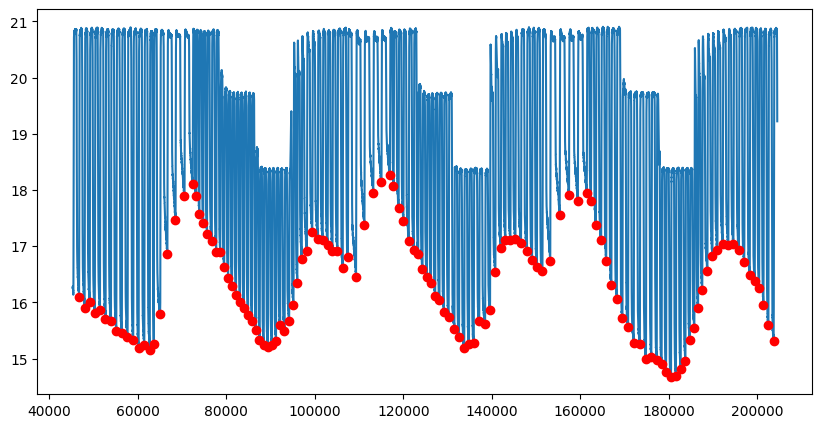

In [19]:
# plot the O2 valleys and CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(O2)
ax.plot(O2valleys_inds, O2valleys_vals, 'ro')

shape of co2 peaks: (134, 1)


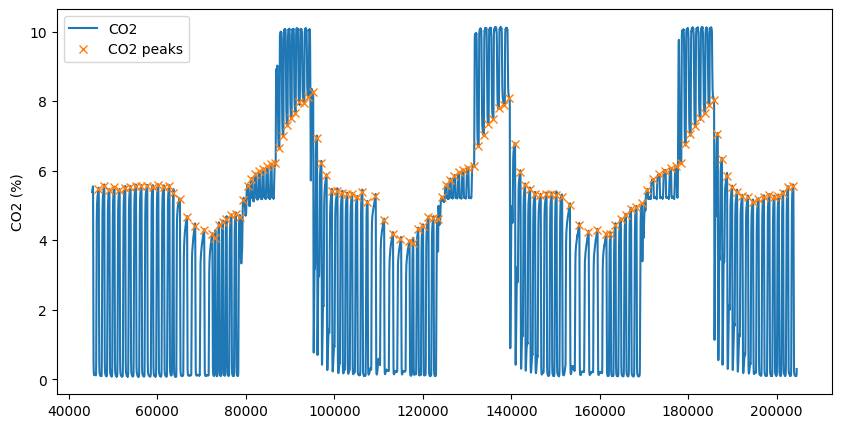

In [20]:
print('shape of co2 peaks:',CO2peaks_df.shape)

# plot the CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(CO2, label='CO2')
ax.plot(CO2peaks_df, 'x', label='CO2 peaks')
ax.legend()
plt.ylabel('CO2 (%)')
plt.show()
 

In [21]:
# # remove large outliers from the PETCO2 data
# # create a function to remove outliers relative to the 2 points before and after (excluding the first and last points)
# def remove_outliers(data, threshold=40):
#     #if the difference between the point and the 2 points before and after is greater than 20% then remove the point
#     print('--- REMOVING OUTLIERS ---')
#     for i in range(2,len(data)-2):
#         if abs(data[i] - data[i-2]) > threshold and abs(data[i] - data[i+2]) > threshold:
#             print('Removing outlier:', data[i])
#             data[i] = np.nan     
#     return data


Removing outlier: 6.949688
Removing outlier: 6.764062
Number of NaN values in CO2 peaks cleaned: CO2    2
dtype: int64


/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_5648/275312571.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  CO2peaks_df_cleaned.iloc[i]['CO2'] = np.nan


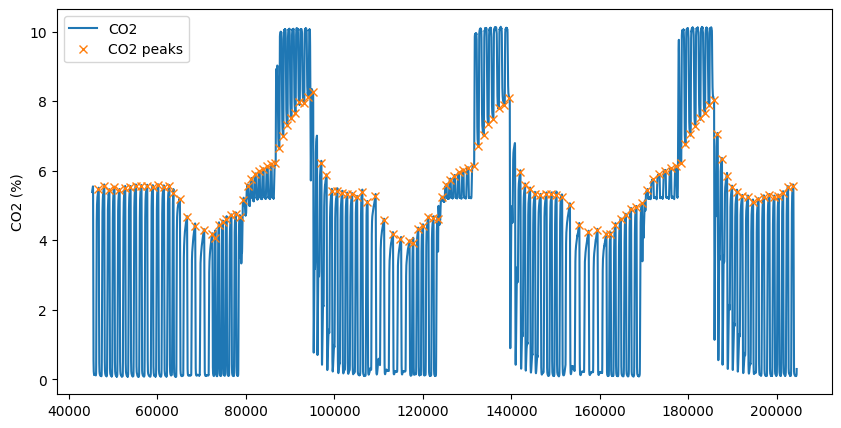

In [22]:
# initialize CO2peaks_df_cleaned 
CO2peaks_df_cleaned = copy.deepcopy(CO2peaks_df)

for i in range(3,len(CO2peaks_df)-3):
    #calculate the mean of the 2 points before and after the current point
    mean_before = np.mean([CO2peaks_df.iloc[i-3]["CO2"], CO2peaks_df.iloc[i-2]['CO2'], CO2peaks_df.iloc[i-1]['CO2']])
    mean_after = np.mean([CO2peaks_df.iloc[i+1]['CO2'], CO2peaks_df.iloc[i+2]['CO2'], CO2peaks_df.iloc[i+3]['CO2']])
    if abs(CO2peaks_df.iloc[i]['CO2'] - mean_before) > peak_dif_thresh and abs(CO2peaks_df.iloc[i]['CO2'] - mean_after) > peak_dif_thresh:
        print('Removing outlier:', CO2peaks_df.iloc[i]['CO2'])
        CO2peaks_df_cleaned.iloc[i]['CO2'] = np.nan

#print the number of NaN values in the cleaned data
print('Number of NaN values in CO2 peaks cleaned:', CO2peaks_df_cleaned.isnull().sum())

# remove the NaN values from the CO2 peaks
CO2peaks_df_cleaned = CO2peaks_df_cleaned.dropna()

# plot the CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(CO2, label='CO2')
ax.plot(CO2peaks_df_cleaned, 'x', label='CO2 peaks')
ax.legend()
plt.ylabel('CO2 (%)')
plt.show()

In [23]:
CO2peaks_df = CO2peaks_df_cleaned

In [24]:
#### TCD ROLLING MEAN ####

print(sample_rate, '1/s')
print('Averaging over', int(20*sample_rate), 'samples = 20 seconds')

# Take a rolling mean of the TCD data with a window of 5 seconds to get the average blood velocity and save it as TCD_rolling not including nan values
TCD_rolling = TCD_th.rolling(int(20*sample_rate)).mean()

# interpolate the nan values in the TCD rolling
TCD_rolling = TCD_rolling.interpolate(method='slinear', limit_direction='both')
#TCD_rolling = TCD_th.rolling(int(20*sample_rate),min_periods=15).mean().fillna(method='bfill')

# print the number of nan values in the TCD rolling
print('Number of NaN values in TCD rolling:', TCD_rolling.isnull().sum())

200.0000000001819 1/s
Averaging over 4000 samples = 20 seconds
Number of NaN values in TCD rolling: 3999


159259
159259
124259
124259


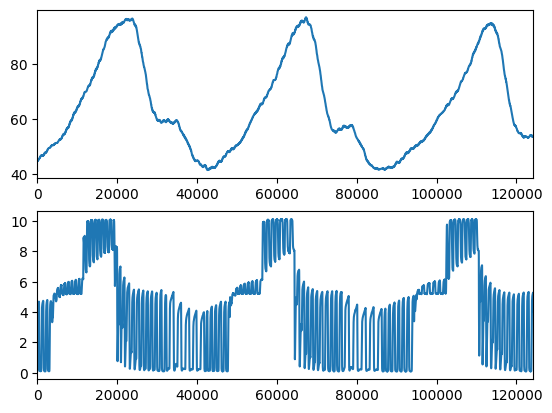

In [25]:
print(len(TCD_rolling))
print(len(CO2))

front_crop = 30000
back_crop = 5000 #5000

A= np.array(TCD_rolling)
B= np.array(CO2)

a=np.ma.masked_invalid(A)
b=np.ma.masked_invalid(B)

msk = (~a.mask & ~b.mask)

# remove first 5 seconds and last 5 seconds of tcd data
func = a[front_crop:-back_crop]
co2 = b[front_crop:-back_crop]

print(len(func))
print(len(co2))

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func)
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(co2)
# use same x axis for both plots
plt.xlim(0, len(co2))
plt.show()


Number of NaN values in CO2: 0
length of func_fft_peaks: 41080
mean of func_fft_peaks: 62129.5
length of co2_fft_peaks: 41519
mean of co2_fft_peaks: 62129.49998795732
length of func_fft after cropping: 124259


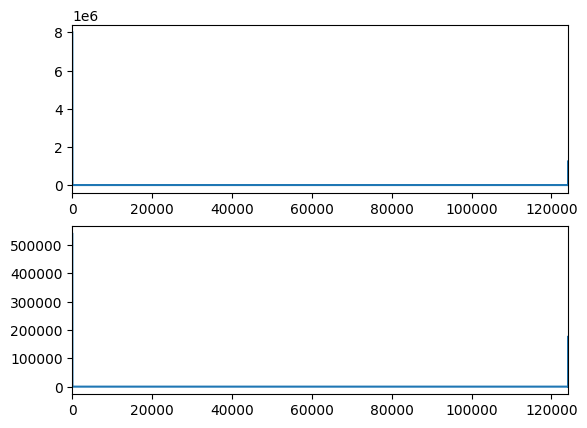

/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


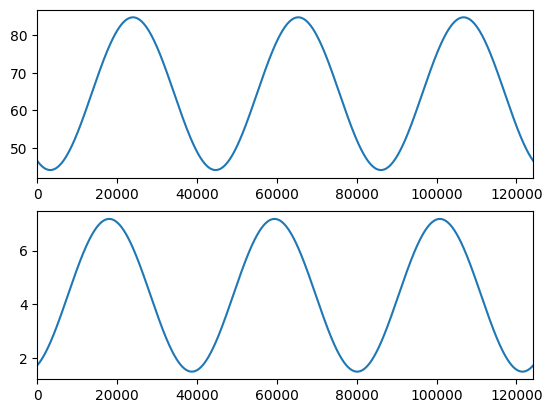

In [26]:
# # Smooth func and co2 data before aligning the signals with cross-correlation
# func_smooth = signal.savgol_filter(func, 17000, 3) # window size 51, polynomial order 3
# co2_smooth = signal.savgol_filter(co2, 25000, 3) # window size 51, polynomial order 3

# remove nan values from co2 data
print('Number of NaN values in CO2:', np.isnan(co2).sum())
co2 = co2[~np.isnan(co2)]

# do a fourier transfrom of func and co2 data and only keep frequencies that are the most prominant
func_fft = fft(func)
co2_fft = fft(co2)

# Keep only the largest frequency peak
# find the peaks in the fft of the func and co2 data
func_fft_peaks, _ = find_peaks(np.abs(func_fft))
co2_fft_peaks, _ = find_peaks(np.abs(co2_fft))
print('length of func_fft_peaks:', len(func_fft_peaks))
print('mean of func_fft_peaks:', np.mean(func_fft_peaks))
print('length of co2_fft_peaks:', len(co2_fft_peaks))
print('mean of co2_fft_peaks:', np.mean(co2_fft_peaks))
# set all frequencies to zero except the largest frequency peak
func_fft[np.abs(func_fft) < np.max(np.abs(func_fft[func_fft_peaks]))] = 0
co2_fft[np.abs(co2_fft) < np.max(np.abs(co2_fft[co2_fft_peaks]))] = 0

print('length of func_fft after cropping:', len(func_fft))

# inverse fourier transform
func_smooth = ifft(func_fft)
co2_smooth = ifft(co2_fft)
# plot the fft of the func and co2 data
plt.figure()
plt.subplot(211)
plt.plot(np.abs(func_fft))
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(np.abs(co2_fft))
# align the x axis of the two plots
plt.xlim(0, len(co2))

plt.show()

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_smooth)
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(co2_smooth)
plt.xlim(0, len(co2))
plt.show()

# print(func_smooth)
# print(co2_smooth)

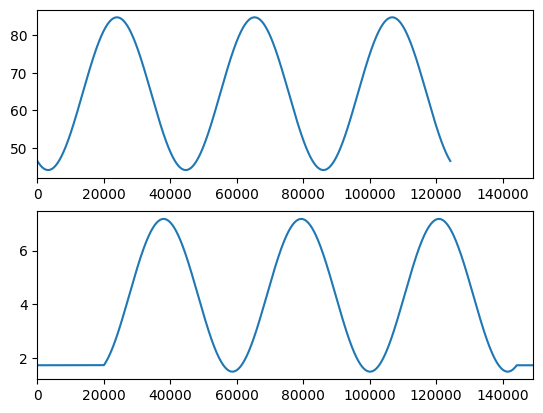

In [27]:
# pad the beginning of co2 with zeros 'front_crop' times and the back with zeros 'back_crop' times
co2_smooth_padded = np.pad(co2_smooth, (20000, back_crop), 'constant', constant_values=(co2_smooth[1], co2_smooth[-1]))

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_smooth)
plt.xlim(0, len(co2_smooth_padded))
plt.subplot(212)
plt.plot(co2_smooth_padded)
plt.xlim(0, len(co2_smooth_padded))
plt.show()

In [28]:
func = func_smooth.copy()
co2 = co2_smooth_padded.copy()

/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


func_smooth_largest_peaks: [84.84242988-7.44951139e-15j 84.84242991-2.16563822e-15j
 84.84242992-8.18902258e-15j]
co2_smooth_largest_peaks: [7.18609538-6.59194451e-16j 7.18609538-2.19759485e-15j
 7.18609538-1.63409743e-15j]
func_smooth_largest_peaks_inds: [1 0 2]
co2_smooth_largest_peaks_inds: [0 2 1]
129311
time_shift: -5052


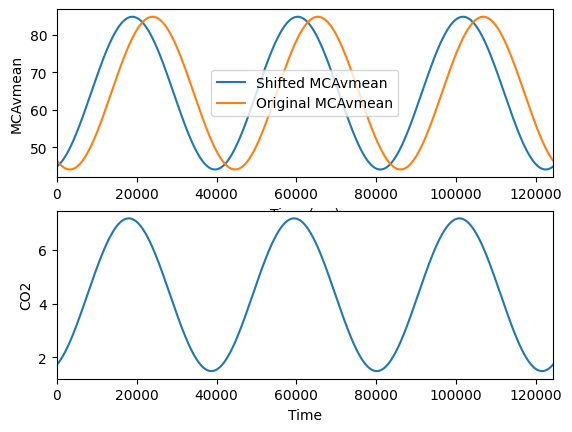

In [29]:
# align the 3 largest peaks in the func_smooth and co2_smooth_padded data
# find the peaks in the func and co2 data
func_smooth_peaks, _ = find_peaks(func_smooth, height=0)
co2_smooth_peaks, _ = find_peaks(co2_smooth_padded, height=0)
# find the 3 largest peaks in the func and co2 data
func_smooth_largest_peaks = np.sort(func_smooth[func_smooth_peaks])[-3:]
co2_smooth_largest_peaks = np.sort(co2_smooth_padded[co2_smooth_peaks])[-3:]
# find the indices of the 3 largest peaks in the func and co2 data
func_smooth_largest_peaks_inds = np.argsort(func_smooth[func_smooth_peaks])[-3:]
co2_smooth_largest_peaks_inds = np.argsort(co2_smooth_padded[co2_smooth_peaks])[-3:]
# print the 3 largest peaks in the func and co2 data
print('func_smooth_largest_peaks:', func_smooth_largest_peaks)
print('co2_smooth_largest_peaks:', co2_smooth_largest_peaks)
# print the indices of the 3 largest peaks in the func and co2 data
print('func_smooth_largest_peaks_inds:', func_smooth_largest_peaks_inds)
print('co2_smooth_largest_peaks_inds:', co2_smooth_largest_peaks_inds)

# align the 3 largest peaks in the func_smooth and co2_smooth_padded data
# find the time shift between func and co2
C = np.correlate(func_smooth,co2_smooth, "full")
# find the index of the maximum value in the correlation
max_corr_ind = np.argmax(C)
print(max_corr_ind)
# find the time shift between the two signals
time_shift = len(co2_smooth) - max_corr_ind
print('time_shift:', time_shift)

# shift the func data by the time shift
func_SHIFT = np.roll(func_smooth, time_shift)
# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_SHIFT, label='Shifted MCAvmean')
plt.plot(func_smooth, label='Original MCAvmean')
plt.xlabel('Time (ms)')
plt.ylabel('MCAvmean')
plt.legend()
plt.xlim(0, len(co2_smooth))

plt.subplot(212)
plt.plot(co2_smooth)
plt.xlim(0, len(co2_smooth))
plt.xlabel('Time')
plt.ylabel('CO2')
plt.show()


In [30]:
# #interations to check 
# iterations = 7000 #12000 #18000
# offset = 10000 #12000 # 15000

# corr_max, corr_max_ind, corr = cvr_func.x_corr(func, co2, iterations, offset, False)

# print('Max xcorr', corr_max)
# print('Max xcorr ind', corr_max_ind)

# xcorr_shift = corr_max_ind - 20000 #corr_max_ind - front_crop

# print('xcorr_shift', xcorr_shift)
# print('time shift', xcorr_shift/sample_rate, 's')

In [31]:
xcorr_shift = time_shift
corr = C

In [32]:
# # save a log file for the cross correlation
# log_file = local + 'sample_data/xcorr_log.csv' 
# # check if the file exists and if not create it

# if not os.path.isfile(log_file):
#     with open(log_file, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(["filename", "xcorr_shift", "time_shift"])
#         writer.writerow([filename, xcorr_shift, xcorr_shift/sample_rate])
#     # otherwise append to the file
# else:
#     with open(log_file, 'a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow([filename, xcorr_shift, xcorr_shift/sample_rate])



corr [ 80.00337069-9.79546103e-14j 159.99618413-1.33804633e-13j
 239.97844411-1.70773718e-13j ... 240.07349307+1.05052385e-14j
 160.03842812-5.37823933e-14j  80.01393168-1.44546343e-13j]


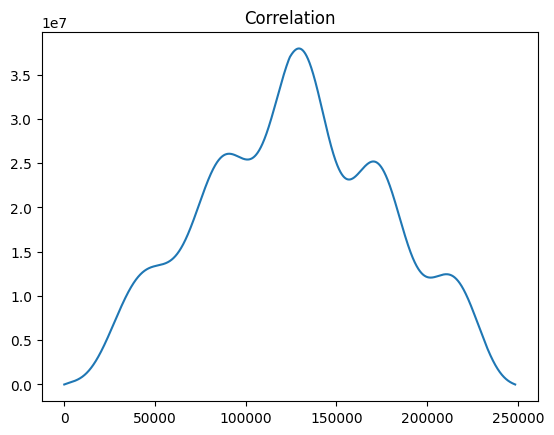

In [33]:
# plot correlation
fig = plt.figure()
plt.plot(corr)
plt.title('Correlation')
print('corr', corr)

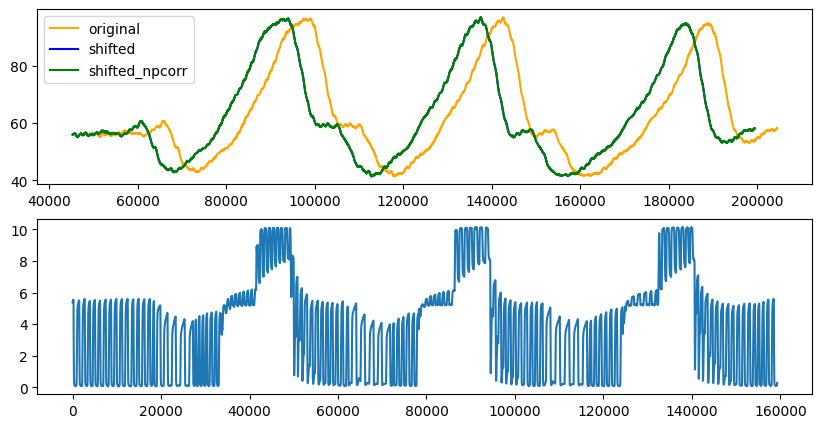

In [34]:
# shift TCD_rolling by the time shift
TCD_rolling_shifted = TCD_rolling.shift(periods=xcorr_shift, fill_value=np.nan)
TCD_rolling_shifted_2 = TCD_rolling.shift(periods=time_shift, fill_value=np.nan)

# plot TCD and CO2 with time shift
fig = plt.figure()
#plot parameters
fig.set_figheight(5)
fig.set_figwidth(10)
tfont = {'fontname':'Times'}
plt.subplot(211)
plt.plot(TCD_rolling, label='original', color='orange')
plt.plot(TCD_rolling_shifted, label='shifted', color='blue')
plt.plot(TCD_rolling_shifted_2, label='shifted_npcorr', color='green')
plt.legend()
#plt.xlim(0, len(TCD_rolling_shifted))
plt.subplot(212)
plt.plot(b)
# use same x axis for both plots
#plt.xlim(0, len(TCD_rolling_shifted))


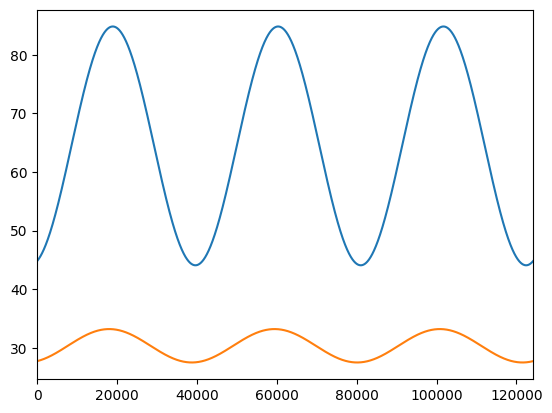

In [35]:
# plot the co2_smooth_padded on the same plot as the func_smooth shifted by the xcorr_shift time shift
plt.figure()
#shift func_smooth numpy array by xcorr_shift and padd the beginning with nans
func_smooth_shifted = np.roll(func, xcorr_shift)
plt.plot(func_smooth_shifted)
plt.plot(co2_smooth+26)

plt.xlim(0, len(co2_smooth))
plt.show()

In [36]:
# # resample the tcd signal to a more resonable length (10x shorter than the original)
# TCD_resampled = resample(TCD_rolling_shifted, int(len(TCD_rolling)/10))
# TCD_rolling_shifted = TCD_resampled

In [37]:
#### CO2 INTERPOLATION ####

# linearly interpolate the peak CO2 values to get the CO2 value at each TCD measurement
CO2peaks_interp = np.interp(TCD_rolling_shifted.index, CO2peaks_df.index, CO2peaks_df['CO2'])

# # interpolate using a cubic spline
# f = sp.interpolate.CubicSpline(CO2peaks_df.index, CO2peaks_df['CO2'], axis = 1 , bc_type='not-a-knot', extrapolate=None)
# CO2peaks_interp = f(TCD_rolling_shifted.index)


In [38]:
#### SCALE CO2 DATA AND O2 DATA FROM PERCENT TO MMHG ####

## DELETE this paragraph - this is the old general estimate of the conversion factor from % to mmHg
# P_oxford = 1012.2 # hPa (Oxford)
# mmHg_per_hPa = 0.75006157584566 # mmHg/hPa
# P_conversion_perc2mmHg = P_oxford*mmHg_per_hPa/100 # conversion factor from % gas concentration to mmHg

print('Conversion factor from % to mmHg:', P_conversion_perc2mmHg)

# Scale the CO2 data from % to mmHg
CO2 = CO2*P_conversion_perc2mmHg
CO2peaks_df = CO2peaks_df*P_conversion_perc2mmHg
CO2peaks_interp = CO2peaks_interp*P_conversion_perc2mmHg

Conversion factor from % to mmHg: 7.650628073625732


In [39]:
TCD_th_shifted = TCD_th.shift(periods=xcorr_shift, fill_value=np.nan)

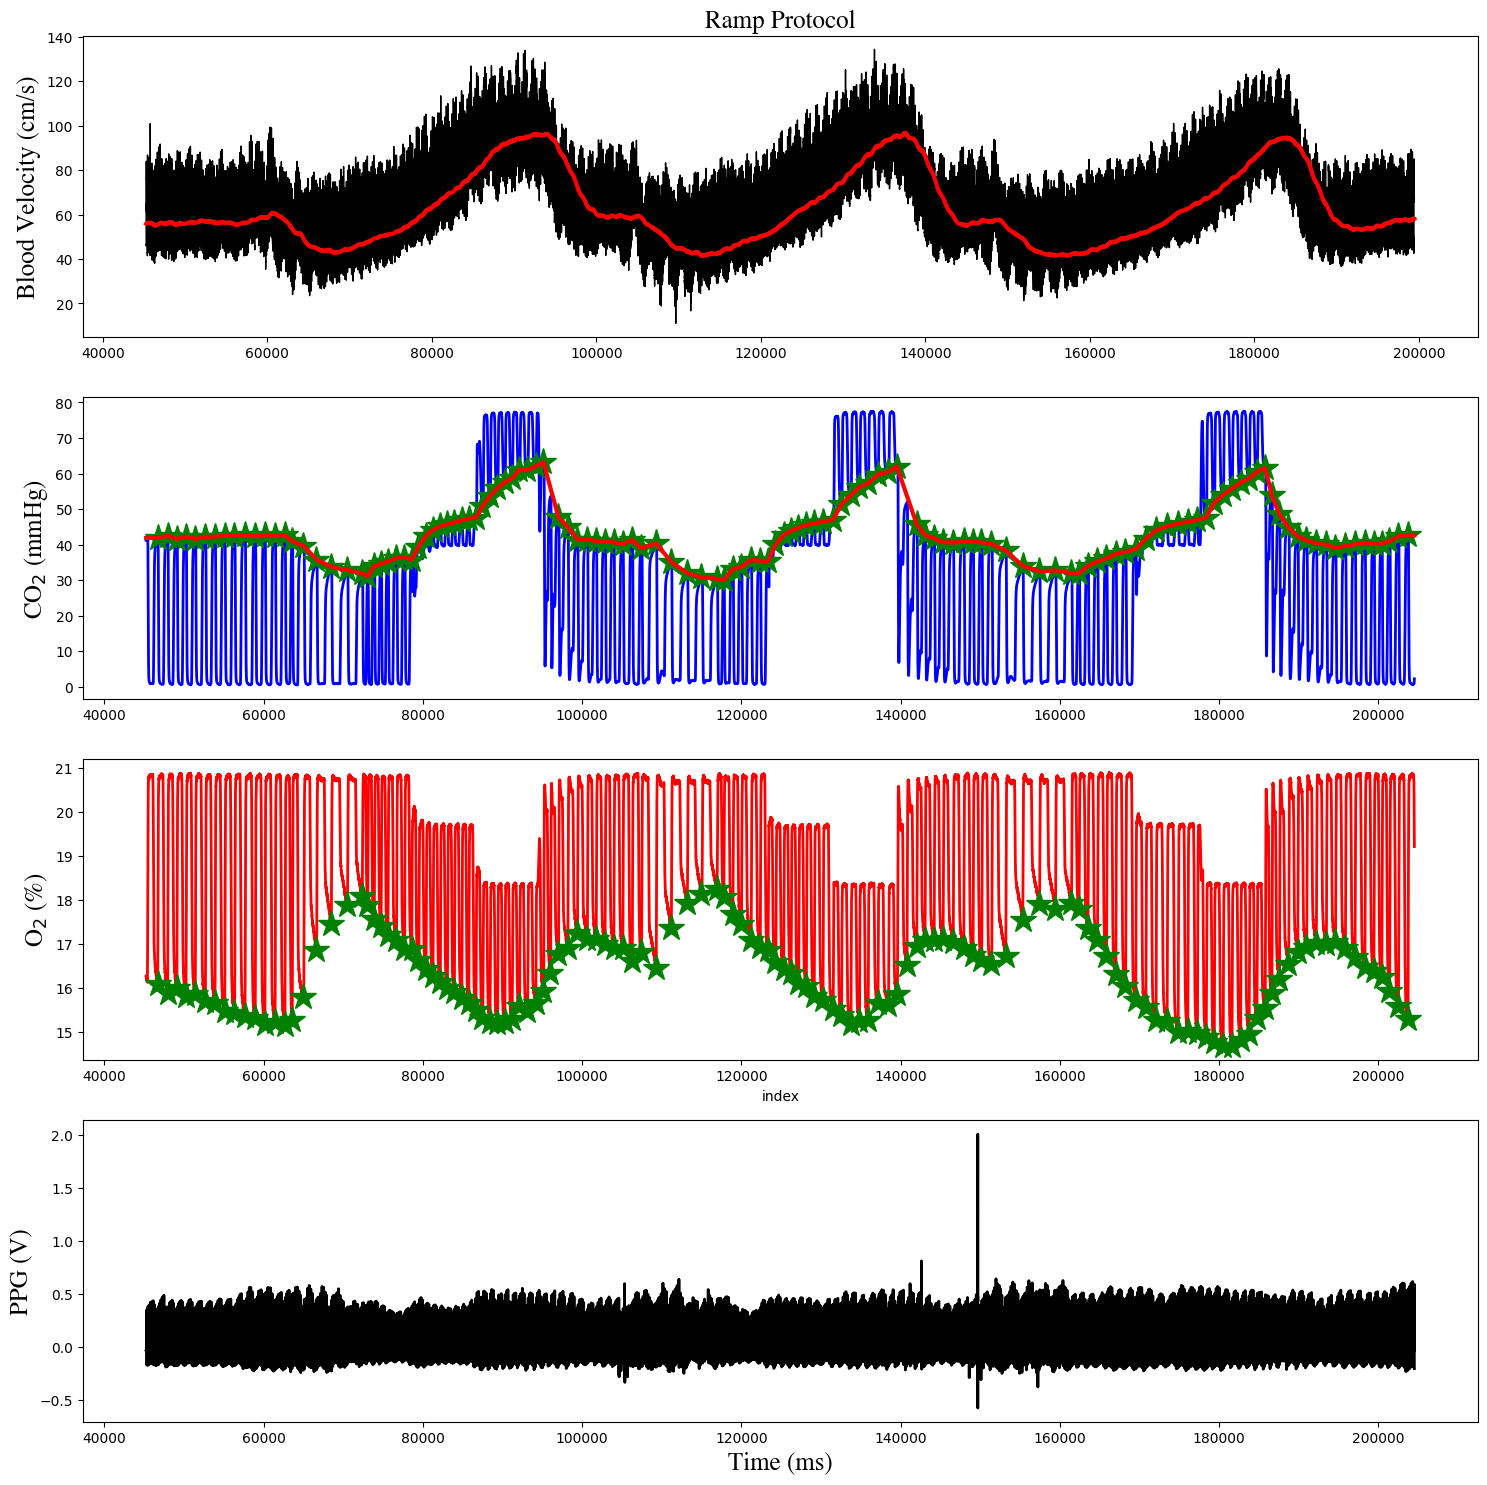

In [40]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp Protocol", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD_th_shifted.plot(c="black", lw=1, legend=False)
#ax1.legend(['MCAvmax', 'MCAvmin', 'MCAvmean'], fontsize=10)
# overlay rolling mean on TCD plot
TCD_rolling_shifted.plot(c="red", lw=3, legend=False)

#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (mmHg)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df.plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g', legend=False)
#ax2.legend(['End-Tidal CO2'], fontsize=10)
# overlay interpolated CO2 on CO2 plot
ax2.plot(TCD_rolling.index, CO2peaks_interp, c="red", lw=3)


#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2, legend=False)
O2valleys_df.plot(ax=ax3,x='index', y = 'val', marker='*',linestyle='None',markersize = 20.0, color = 'g', legend=False)
#ax3.legend(['End-Tidal O2'], fontsize=10)


#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="black", lw=2, legend=False)


plt.show()

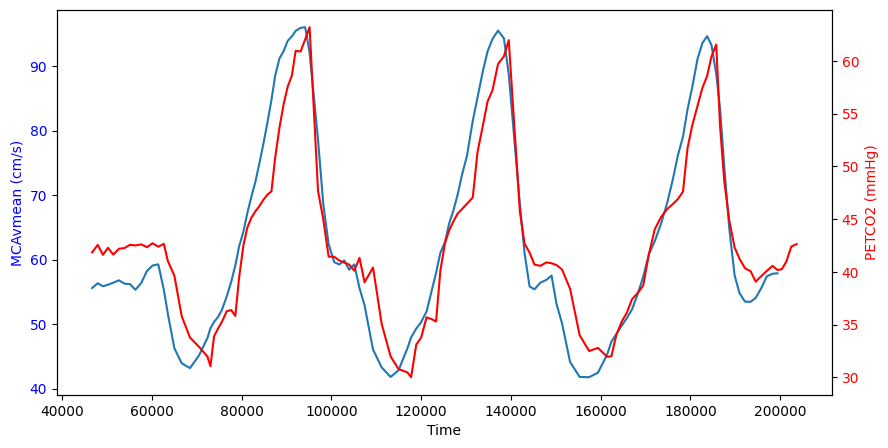

In [41]:
# Plot the first column of mca relative to its index
# Define figure 
fig = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted.loc[CO2peaks_df.index])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_df,'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')


159259
132
132
159259


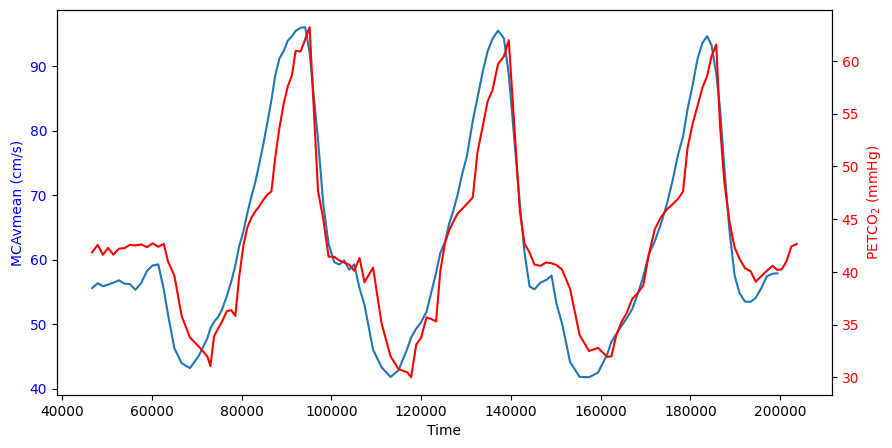

In [42]:
# manually shift the TCD_rolling_shifted data to align with the CO2 peaks
TCD_rolling_shifted_manual = TCD_rolling_shifted.shift(periods=man_shift, fill_value=np.nan)
# crop the end of CO2peaks_df to match the length of TCD_rolling_shifted_manual
CO2peaks_df_manual = CO2peaks_df.iloc[:len(TCD_rolling_shifted_manual)]

# Define figure 
fig5 = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted_manual.loc[CO2peaks_df_manual.index])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_df_manual,'r')
ax2.set_ylabel('PETCO$_{2}$ (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

print(len(TCD_rolling_shifted_manual))
print(len(TCD_rolling_shifted_manual.loc[CO2peaks_df_manual.index]))
print(len(CO2peaks_df_manual))
print(len(CO2peaks_interp))

In [43]:
# save a copy of the figure in as a png in the same folder
if save_fig == True:    
    fig5.savefig(sub_outdir + sub + '_' + ses + '_' + date + '_' + task + '_MCAvsPETCO2peaks_manshifted.png')

In [44]:
# # remove the NAN values from the TCD_rolling_shifted_manual and CO2peaks_interp
# #TCD_rolling_shifted_manual, CO2peaks_interp = cvr_func.remove_nans(TCD_rolling_shifted_manual, CO2peaks_interp)

# #get the indices of all nans in the data and remove them
# nan_idx_mca = np.argwhere(np.isnan(TCD_rolling_shifted_manual))
# nan_idx_petco2 = np.argwhere(np.isnan(CO2peaks_interp))
# # combine the indices of the nans
# nan_idx = np.concatenate((nan_idx_mca,nan_idx_petco2),axis=0)
# print('Removing', len(nan_idx), 'nan values from both datasets')
# # remove the nans from the mca and petco2 data
# TCD_rolling_shifted_manual = TCD_rolling_shifted_manual.drop(nan_idx[:,0])
# CO2peaks_interp = CO2peaks_interp.drop(nan_idx[:,0])

# # reset the index of the mca and petco2 data after removing the nans
# TCD_rolling_shifted_manual = TCD_rolling_shifted_manual.reset_index(drop=True)
# CO2peaks_interp = CO2peaks_interp.reset_index(drop=True)

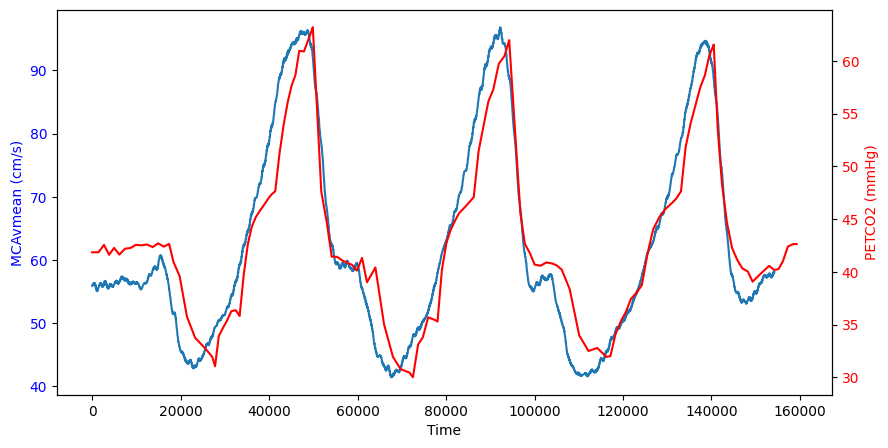

In [45]:
#reset the index of the tcd data
TCD_rolling_shifted_manual = TCD_rolling_shifted_manual.reset_index(drop=True)

# Define figure 
fig_interp_shift = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted_manual)
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_interp,'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

In [46]:
# I don't think I need this resample, will delete later

# TCD_rolling_shifted_manual = pd.DataFrame(TCD_rolling_shifted_manual)
# CO2peaks_df_manual = pd.DataFrame(CO2peaks_df_manual)
# # reset the index of the TCD_rolling_shifted_manual data
# TCD_rolling_shifted_manual.reset_index(inplace=True)
# # reset the index of the CO2peaks_df_manual data
# CO2peaks_df_manual.reset_index(inplace=True)

# #print the header of the first column of the TCD_rolling_shifted_manual data
# print(TCD_rolling_shifted_manual.head())
# #print the header of the CO2peaks_df_manual data
# print(CO2peaks_df_manual.head())

# # resample the TCD_rolling_shifted_manual data to 2 Hz
# TCD_rolling_shifted_manual_resampled = TCD_rolling_shifted_manual.resample('500L', on='Time').mean()
# # resample the CO2peaks_df_manual data to 2 Hz
# CO2peaks_df_manual_resampled = CO2peaks_df_manual.resample('500L', on='Time').mean()

In [47]:
print('shape of co2 interp', CO2peaks_interp.shape)

shape of co2 interp (159259,)


In [48]:
#petco2_final = CO2peaks_df_manual_resampled
petco2_final = CO2peaks_interp
tcd_rolling_final = TCD_rolling_shifted_manual
#TCD_th_manshifted = TCD_th.shift(periods=(man_shift), fill_value=np.nan)

In [49]:
# print size and datatype of TCD_rolling
print('Size of TCD_rolling:', len(tcd_rolling_final))
print('Datatype of TCD_rolling:', type(tcd_rolling_final))
# print size and datatype of CO2peaks_interp
print('Size of CO2peaks_interp:', len(petco2_final))
print('Datatype of CO2peaks_interp:', type(petco2_final))


Size of TCD_rolling: 159259
Datatype of TCD_rolling: <class 'pandas.core.series.Series'>
Size of CO2peaks_interp: 159259
Datatype of CO2peaks_interp: <class 'numpy.ndarray'>


In [50]:
# label the first header of TCD_rolling "time (ms)" and the second header "MCAvmean (cm/s)"
tcd_rolling_header = ['MCAvmean (cm/s)']
# label the first header of CO2peaks_interp "time (ms)" and the second header "PETCO2 (mmHg)"
petco2_header = ['PETCO2 (mmHg)']

# give TCD_rolling and CO2peaks_interp headers
tcd_rolling_final = pd.DataFrame(tcd_rolling_final)
tcd_rolling_final.columns = tcd_rolling_header
petco2_final = pd.DataFrame(petco2_final)
petco2_final.columns = petco2_header

print('SHAPE OF TCD ROLLING FINAL:', tcd_rolling_final.shape)
print('SHAPE OF PETCO2 FINAL:', petco2_final.shape)

#print the number of NaN values in the TCD_rolling_final data and the CO2peaks_interp data
print('Number of NaN values in TCD_rolling_final:', tcd_rolling_final.isnull().sum())
print('Number of NaN values in PETCO2_final:', petco2_final.isnull().sum())

SHAPE OF TCD ROLLING FINAL: (159259, 1)
SHAPE OF PETCO2 FINAL: (159259, 1)
Number of NaN values in TCD_rolling_final: MCAvmean (cm/s)    5052
dtype: int64
Number of NaN values in PETCO2_final: PETCO2 (mmHg)    0
dtype: int64


# Save the CSV files with the preprocessed data

In [51]:
# save TCD_rolling and CO2peaks_interp as csv files of the same format and make name files the same as the original file but with _TCD_rolling and _CO2peaks_interp and save files in the same directory as the original file but in a folder called sample data

# generate the new filenames
tcd_rolling_filename = sub + '_' + ses + '_' + date + '_' + task + '_MCAvmean.csv'
petco2_filename = sub + '_' + ses + '_' + date + '_' + task + '_petco2.csv'

# save the TCD_rolling and petco2 data as csv files
tcd_rolling_final.to_csv(sub_outdir + tcd_rolling_filename)
petco2_final.to_csv(sub_outdir + petco2_filename)

In [52]:
total_time_shift_applied_sec = int(time_shift+man_shift)/sample_rate
print('total_time_shift_applied_sec:', total_time_shift_applied_sec)

total_time_shift_applied_sec: -25.259999999977026


In [53]:
# save total_time_shift_applied_sec into a csv

print('Subject TCD-:', sub)

csv_time_shift_parameters = outdir + 'time_shift_log_tcd.csv'
time_shift_parameters = pd.DataFrame({'sub-tcd':[sub],'total_time_shift_applied_sec':[total_time_shift_applied_sec], 'xcorr_shift_sec':[int(time_shift)/200]})
# if the file does not exist, create it
if not os.path.exists(csv_time_shift_parameters):
    time_shift_parameters.to_csv(csv_time_shift_parameters, index=False)
    print('Time shift log saved to new file:', csv_time_shift_parameters)
# if the file exists, append to it
else:
    time_shift_parameters.to_csv(csv_time_shift_parameters, mode='a', header=False, index=False)
    print('Time shift parameter log appended to existing file:', csv_time_shift_parameters)

Subject TCD-: sub-009
Time shift parameter log appended to existing file: /Users/ghayes/Desktop/ramp_protocol/data/TCD/tcd_proc/time_shift_log_tcd.csv


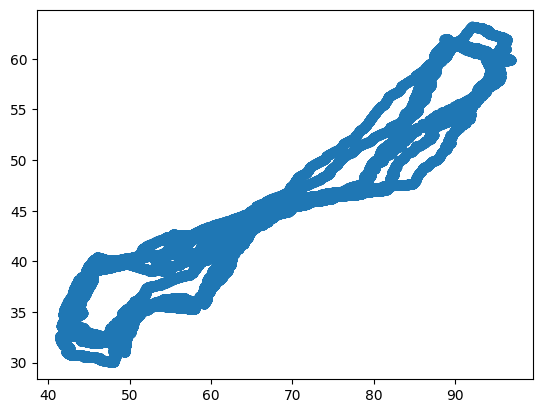

In [54]:
# plot the TCD_rolling as a function of CO2peaks_interp data
fig_comparison = plt.figure()
plt.plot(TCD_rolling_shifted, CO2peaks_interp, 'o')


Shape of TCD_rolling_CO2peaks: (132,)
Shape of CO2peaks_df: (132, 1)


Text(0, 0.5, 'TCD_rolling (cm/s)')

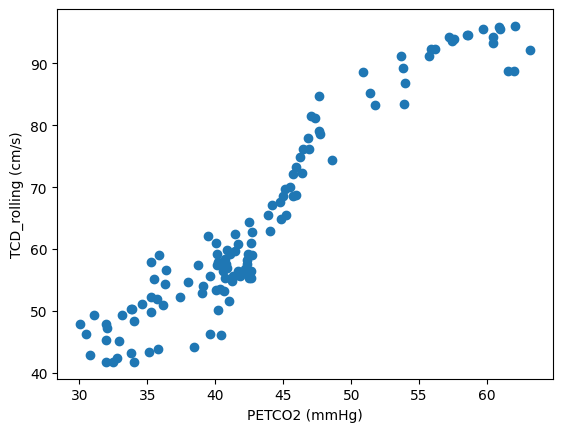

In [55]:
# get the tcd value from the TCD_rolling dataframe that is closest to each CO2 peak index
TCD_rolling_CO2peaks = TCD_rolling_shifted.loc[CO2peaks_df.index]
# print the shape of TCD_rolling_CO2peaks and CO2peaks_df
print('Shape of TCD_rolling_CO2peaks:', TCD_rolling_CO2peaks.shape)
print('Shape of CO2peaks_df:', CO2peaks_df.shape)

# plot the TCD_rolling_CO2peaks vs. CO2peaks_df
fig_scatter = plt.figure()
ax = fig_scatter.add_subplot(111)
ax.plot(CO2peaks_df, TCD_rolling_CO2peaks, 'o')
ax.set_xlabel('PETCO2 (mmHg)')
ax.set_ylabel('TCD_rolling (cm/s)')



In [56]:
# save a copy of the figure in as a png in the same sample_data folder
if save_fig == True:    
    fig_scatter.savefig(sub_outdir + sub + '_' + ses + '_' + date + '_' + task + '_scatter_comparison.png')

In [57]:
############################################################################

In [58]:
peaks_inds, peaks_vals, peaks_df = cvr_func.get_tcd_peaks(TCD_th, TCD_th.index[0], search_window=6, sample_rate=200, height=0, prominence=2)
valleys_inds, valleys_vals, valleys_df = cvr_func.get_tcd_valleys(TCD_th, TCD_th.index[0], search_window=6, sample_rate=200, height=-50, prominence=1)

print('peaks', peaks_inds)
print('valleys', valleys_inds)
print('peaks', peaks_df)
print('valleys', valleys_df)

peaks [ 45781  47266  49491  50805  52010  54106  55689  58035  59521  61719
  63033  65384  66751  68648  70715  72558  74316  75778  77985  79189
  80416  82362  84309  86128  87994  89834  91045  92294  93563  94819
  96364  98777  99993 101343 103205 105311 106691 108037 109923 111507
 113469 115232 117112 118378 120284 121509 123251 124510 125832 127638
 129323 130696 131925 133128 135349 137303 138870 140134 141381 142609
 143816 145621 146977 148206 149676 151971 153414 154715 156307 157750
 159761 161480 163645 164962 167524 169908 171110 172480 174020 175245
 176481 177719 179622 180839 182759 184068 185983 188032 189250 190618
 192558 194910 196124 197533 198773 200595 201871 204106]
valleys [ 45290  47452  49004  51338  53656  54994  57362  58718  60007  61215
  62547  64842  66432  68114  70190  71619  72998  75457  77517  79279
  80557  82026  83807  85104 100512 102541 103913 106194 107626 108986
 110983 112947 114707 116527 118729 120916 123236 124833 126144 127967
 1298

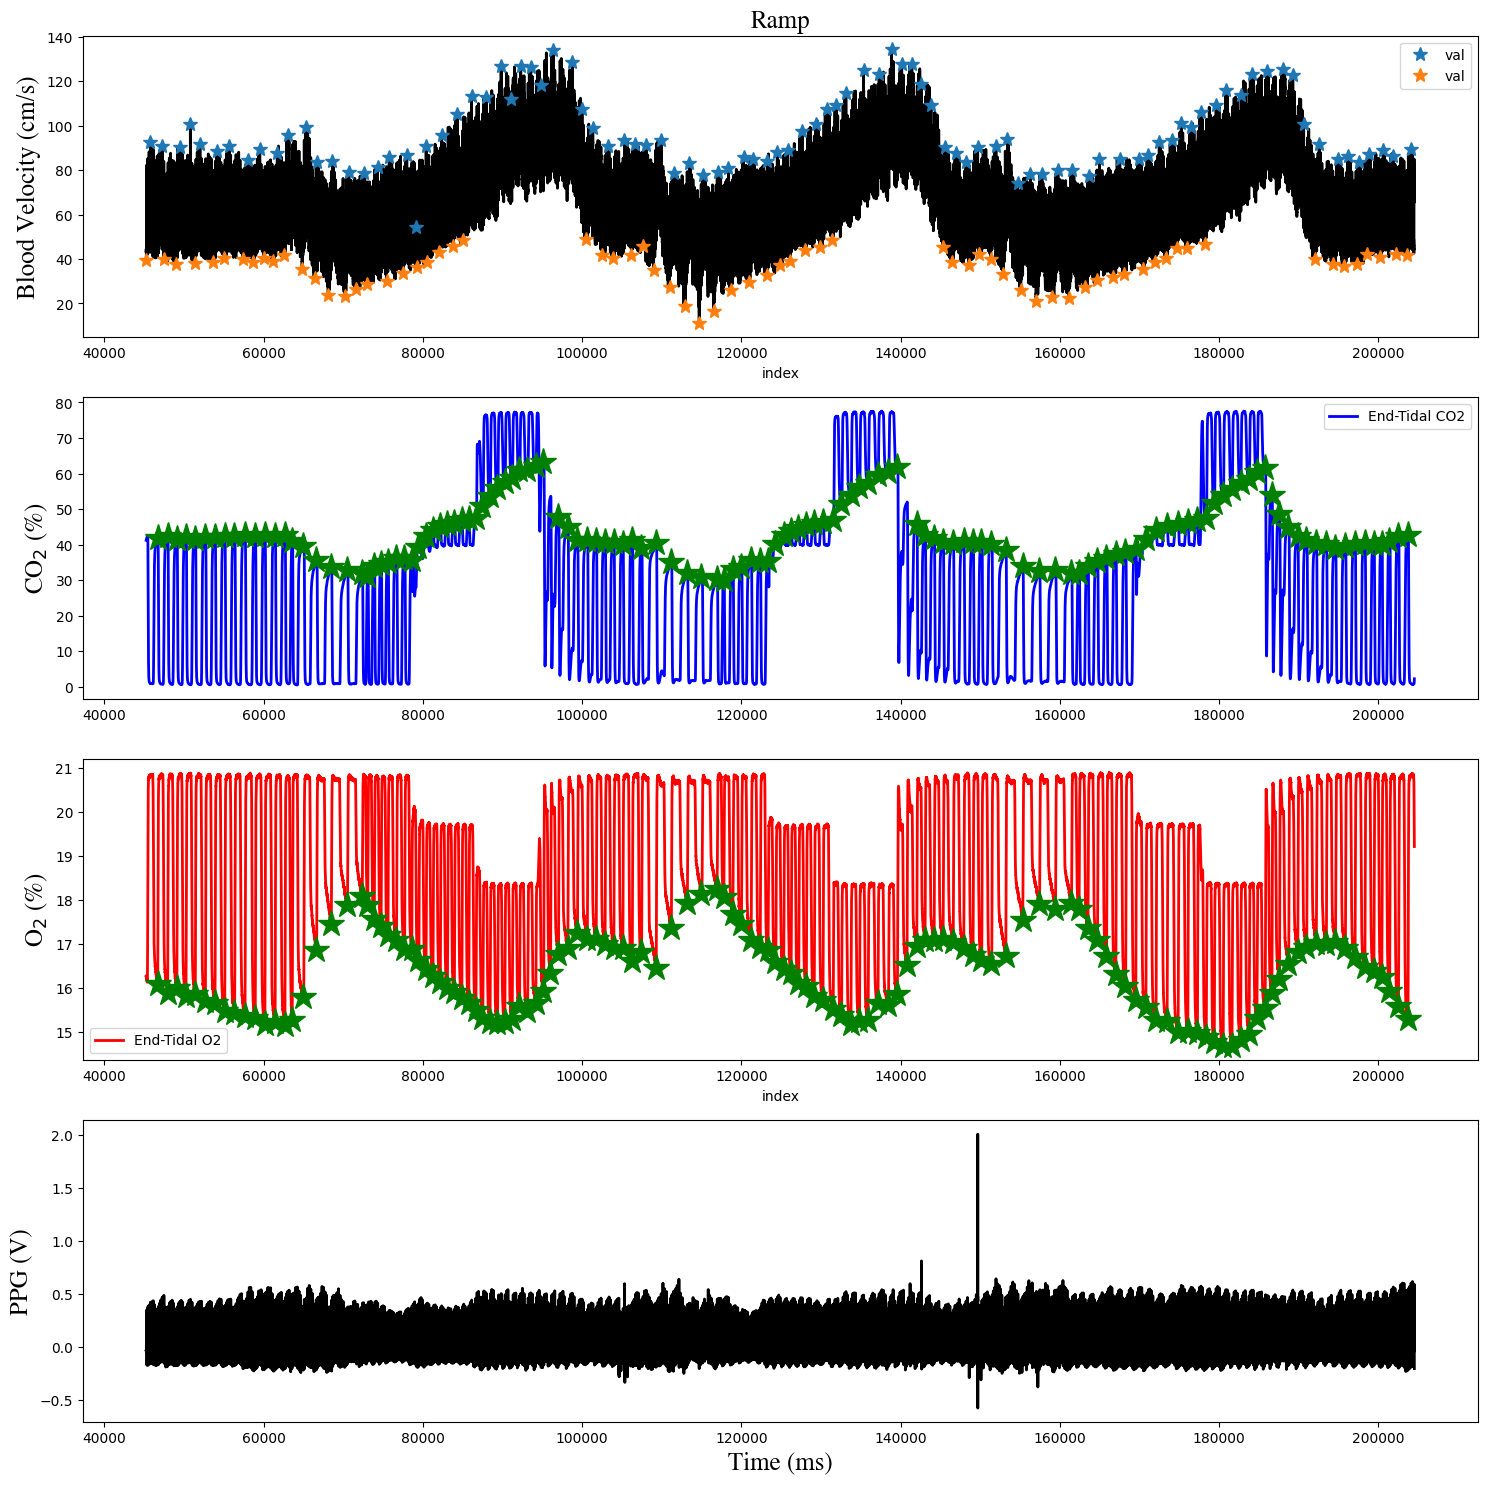

In [59]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD_th.plot(c="black", lw=2)
peaks_df.plot(ax=ax1, x='index', y='val',marker='*',linestyle='None',markersize = 10.0)
valleys_df.plot(ax=ax1, x='index', y='val',marker='*',linestyle='None',markersize = 10.0)


#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (%)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df.plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax2.legend(['End-Tidal CO2'], fontsize=10)


#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2)
O2valleys_df.plot(ax=ax3,x='index', y = 'val', marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax3.legend(['End-Tidal O2'], fontsize=10)


#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="black", lw=2)

plt.show()


In [60]:
# Get the average TCD velocity within the tcd_window_size
tcd_window_size = 0.5 # seconds
tcd_window_size *= sample_rate
tcd_window_size = int(tcd_window_size)
print('TCD window size:', tcd_window_size, 'samples')
print(TCD_th.loc[1:3])


# Get the average TCD velocity within the tcd_window_size for each of the end tidal CO2 peaks
CO2peaks_tcd = []
for i in range(len(CO2peaks_inds)-1):
    tcd_start_window = CO2peaks_inds[i]-tcd_window_size
    tcd_end_window = CO2peaks_inds[i]+tcd_window_size
    print(tcd_start_window)
    print(tcd_end_window)
    print(TCD_th[tcd_start_window:tcd_end_window])
    print('_____')
    CO2peaks_tcd.append(np.nanmean(TCD_th.loc[tcd_start_window:tcd_end_window]))
CO2peaks_tcd = np.array(CO2peaks_tcd)

print('CO2peaks_tcd', CO2peaks_tcd)



TCD window size: 100 samples
Series([], Name: Channel 3 - TCD, dtype: float64)
46589
46789
91848    104.129197
91849    105.928873
91850    106.055187
91851    104.223907
91852    104.508078
            ...    
92043    103.181994
92044    103.055700
92045     98.035513
92046     98.351248
92047     98.351248
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
47840
48040
93099    92.636466
93100    94.025697
93101    93.709962
93102    93.899403
93103    86.542782
           ...    
93294    96.583155
93295    96.772576
93296    92.541735
93297    92.541735
93298    92.762759
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
48991
49191
94250    117.768922
94251    118.084656
94252    116.695425
94253    116.348107
94254    116.442838
            ...    
94445    111.801532
94446    111.833116
94447    104.255491
94448    104.444931
94449    104.287054
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
50129
50329
95388    107.160247
95389    106.970806
95390    106.

In [61]:
print('CO2 peak values : ', CO2peaks_vals.shape)
print('CO2peaks_tcd.shape : ', CO2peaks_tcd.shape)

vals_range_end = 24
tcd_range_end = 24

CO2 peak values :  (134,)
CO2peaks_tcd.shape :  (133,)


In [62]:
# #plot
# fig = plt.figure()

# #plot parameters
# fig.set_figheight(10)
# fig.set_figwidth(10)
# tfont = {'fontname':'Times'}

# plt.plot(CO2peaks_vals[0:vals_range_end],CO2peaks_tcd[0:tcd_range_end],'*r')
# plt.xlabel('End-Tidal CO2 (%)', fontsize=18, **tfont)
# plt.ylabel('TCD Velocity (cm/s)', fontsize=18, **tfont)

In [63]:
## Trial sigmoid fit

# # fit a sigmoid to the CO2 data vs. end tidal CO2 data
# from scipy.optimize import curve_fit

# # def sigmoid(x, a, b, c):
# #     return a / (1 + np.exp(-b*(x-c)))

# # popt, pcov = curve_fit(sigmoid, CO2peaks_vals[:-1], CO2peaks_tcd[:])
# # print(popt)


# def sigmoid(x, L ,x0, k, b):
#     return L / (1 + np.exp(-k*(x-x0))) + b

# p0 = [max(CO2peaks_tcd[:]), np.median(CO2peaks_vals[:-1]),1,min(CO2peaks_tcd[:])] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, CO2peaks_vals[:-1], CO2peaks_tcd[:],p0, method='dogbox')

# #plot
# fig = plt.figure()

# #plot parameters
# fig.set_figheight(10)
# fig.set_figwidth(10)
# tfont = {'fontname':'Times'}

# plt.plot(CO2peaks_vals[:-1],CO2peaks_tcd[:],'*r')
# #plt.plot(CO2peaks_vals[:-1], sigmoid(CO2peaks_vals[:-1], *popt), 'b-')
# plt.xlabel('End-Tidal CO2 (%)', fontsize=18, **tfont)
# plt.ylabel('TCD Velocity (cm/s)', fontsize=18, **tfont)



In [64]:
## Other trial sigmoid fit

# # fit a sigmoid to the CO2 data vs. end tidal CO2 data
# from scipy.optimize import curve_fit

# # def sigmoid(x, a, b, c):
# #     return a / (1 + np.exp(-b*(x-c)))

# # popt, pcov = curve_fit(sigmoid, CO2peaks_vals[:-1], CO2peaks_tcd[:])
# # print(popt)


# def sigmoid(x, L ,x0, k, b):
#     return L / (1 + np.exp(-k*(x-x0))) + b

# p0 = [max(CO2peaks_tcd[:]), np.median(CO2peaks_vals[:-1]),1,min(CO2peaks_tcd[:])] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, CO2peaks_vals[:-1], CO2peaks_tcd[:],p0, method='dogbox')

# #plot
# fig = plt.figure()

# #plot parameters
# fig.set_figheight(10)
# fig.set_figwidth(10)
# tfont = {'fontname':'Times'}

# plt.plot(CO2peaks_vals[:-1],CO2peaks_tcd[:],'*r')
# plt.plot(CO2peaks_vals[:-1], sigmoid(CO2peaks_vals[:-1], *popt), 'b-')
# plt.xlabel('End-Tidal CO2 (%)', fontsize=18, **tfont)
# plt.ylabel('TCD Velocity (cm/s)', fontsize=18, **tfont)

/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_5648/2494397332.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.arange(0, len(CO2peaks_interp), step=100))


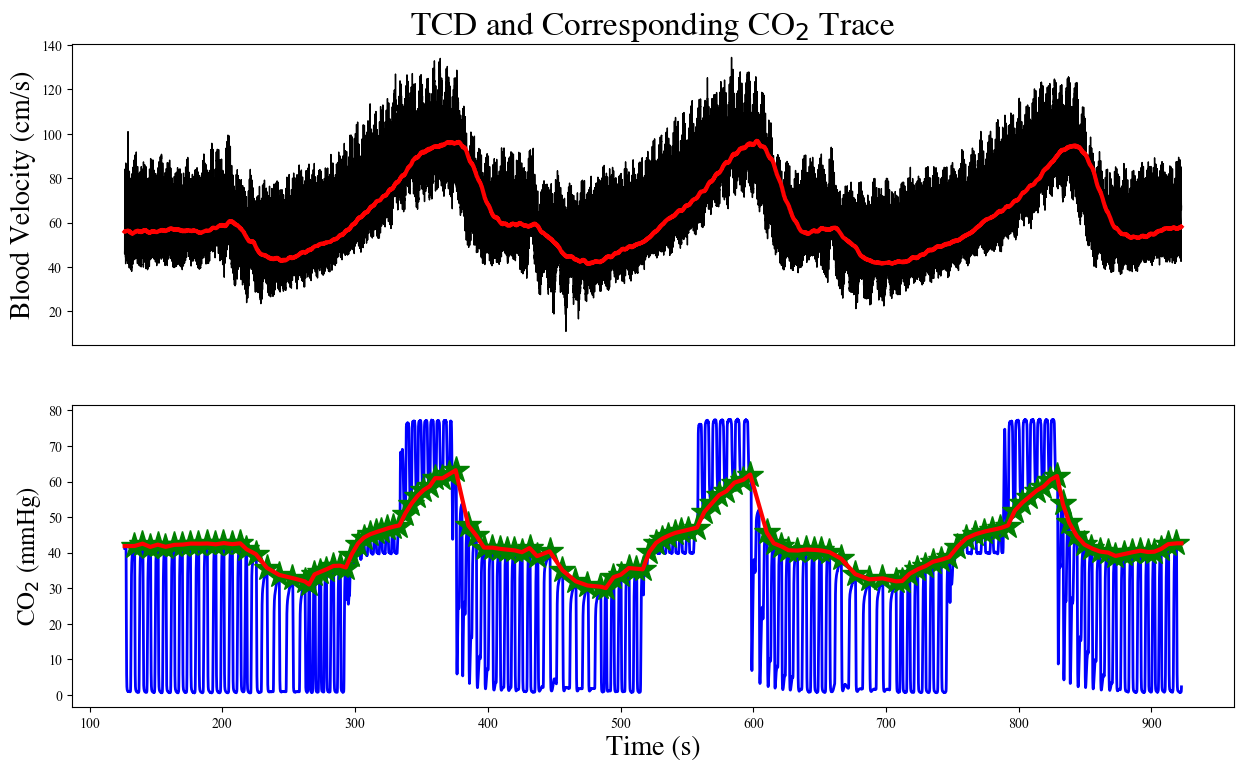

In [82]:
# # remove values above 80 cm/s and below 20 cm/s
# TCD_th_shifted = TCD_th_shifted.mask(TCD_th_shifted > 130)
# TCD_th_shifted = TCD_th_shifted.mask(TCD_th_shifted < 1)

# #crop out the first 60000 samples
# TCD_th_shifted = TCD_th_shifted[60000:]
# CO2 = CO2[60000:]
# CO2peaks_interp = CO2peaks_interp[60000:]
# TCD_rolling_shifted = TCD_rolling_shifted[60000:]
# TCD_rolling = TCD_rolling[60000:]
# CO2peaks_df = CO2peaks_df[60000:]

# print('TCD_th_manshifted[front_crop:] : ', TCD_th_manshifted[front_crop:])
# print('TCD_rolling_shifted[front_crop:] : ',TCD_rolling_shifted[front_crop:])
# print('number of NaN values in TCD_rolling_shifted:', TCD_rolling_shifted.isnull().sum())
# print('man_shift:', man_shift)

# set the figure font to all times

# Set figure font to Times
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'


front_crop = 0

#plot
fig_overview = plt.figure()

#plot parameters
fig_overview.set_figheight(18)
fig_overview.set_figwidth(15)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig_overview.add_subplot(411)
ax1.set_title("TCD and Corresponding CO$_{2}$ Trace", fontsize=24, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=20, **tfont)
TCD_th_shifted.plot(c="black", lw=1, legend=False)
#ax1.legend(['MCAvmax', 'MCAvmin', 'MCAvmean'], fontsize=10)
# overlay rolling mean on TCD plot
TCD_rolling_shifted.plot(c="red", lw=3, legend=False)
#remove x axis labels and ticks
ax1.set_xticklabels([])
ax1.set_xticks([])


#plot CO2 percentage
ax2 = fig_overview.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (mmHg)', fontsize=18, **tfont)
CO2[front_crop:].plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df[front_crop:].plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g', legend=False)
#ax2.legend(['End-Tidal CO2'], fontsize=10)
# overlay interpolated CO2 on CO2 plot
ax2.plot(TCD_rolling[front_crop:].index, CO2peaks_interp[front_crop:], c="red", lw=3)
ax2.set_xlabel('Time (s)', fontsize=20, **tfont) 
#scale the x axis labels by 5 to convert to ms
ax2.set_xticklabels(np.arange(0, len(CO2peaks_interp), step=100))


plt.show()

In [66]:
# save a copy of the figure in as a png
if save_fig == True:    
    fig_overview.savefig(sub_outdir + sub + '_' + ses + '_' + date + '_' + task + '_fulltraces_overview.png')

In [67]:
print(sub_outdir+ sub + '_' + ses + '_' + date + '_' + task + '_fulltraces_overview.png')

/Users/ghayes/Desktop/ramp_protocol/data/TCD/tcd_proc/sub-009/ses-02/sub-009_ses-02_20240830_task_task-ramp_fulltraces_overview.png
